In [46]:
import os
import cv2
import keras
import pickle
import random
import numpy as np
import pandas as pd
#from PIL import Image
from PIL import Image 
import matplotlib.pyplot as plt 
from tqdm import tqdm
from keras import backend as K
from sklearn.metrics import classification_report,confusion_matrix,plot_confusion_matrix
from sklearn import metrics
#from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential,load_model 
from keras.layers import Activation,Dropout,Flatten,Conv2D,Dense,MaxPool2D
from keras.optimizers import Adam,SGD 
from keras.metrics import categorical_crossentropy
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
print("____ok")

____ok


**Dirs and parametrs**

In [0]:
train_dir = '/content/drive/My Drive/Colab Notebooks/WeaponProject/Dataset/train/'
valid_dir = '/content/drive/My Drive/Colab Notebooks/WeaponProject/Dataset/validation/'
test_dirr='/content/drive/My Drive/Colab Notebooks/WeaponProject/Dataset/test/'
class_names=["Handgun", "Knife","Rifle"]
training_samples = 855 
validation_samples = 50  #i dont have just 50img in validation i must change this to 60 and try to fit the model agin

**Data Generator**

In [36]:
batch_size = 32
# augmentation configuration for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        rotation_range=45,
        horizontal_flip=True)

#  augmentation configuration  for testing:
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(224, 224),  
        batch_size=batch_size,
        classes=class_names,
        class_mode='categorical')  

#i wll try it by the train-datgen 'zoom and range and ...'
validation_generator = train_datagen .flow_from_directory(
        valid_dir,
        target_size=(224, 224),  
        batch_size=15,
       classes=class_names,
       class_mode='categorical')  #because i have mor then 2 classes 'binary clasifacation'
test_generator=test_datagen.flow_from_directory(    
        test_dirr,
        target_size=(224, 224), 
       classes=class_names,
       batch_size=10,
        class_mode='categorical')

Found 855 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
Found 80 images belonging to 3 classes.


In [37]:
X_train, y_train = train_generator.next()
X_test, y_test = test_generator.next()
print(X_train.shape)
print(y_test.shape)

(32, 224, 224, 3)
(10, 3)


**Scater of train/test**

In [0]:
plt.scatter(X_train, y_train, c='blue', label='Train set')
plt.scatter(X_test, y_test, c='red', label='Test set')
plt.legend()

**VGG16-(CNN ) architecture**

3x3 filter

maxpool layer of 2x2 filter of stride 2

2 FC

 The 16 in VGG16 refers to it has 16 layers that have weights
 

In [0]:
model = Sequential()
model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
#FC
model.add(Flatten())
model.add(Dense(4096,activation="relu"))
model.add(Dense(4096,activation="relu"))
model.add(Dropout(0.5)) 

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(12, activation='relu'))
model.add(Dropout(0.3)) 

model.add(Dense(3, activation='softmax', name='Output'))

**Show information about My Model architector**

In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 256)      

**Show the Mdel Diagrame**
and save the diagrame

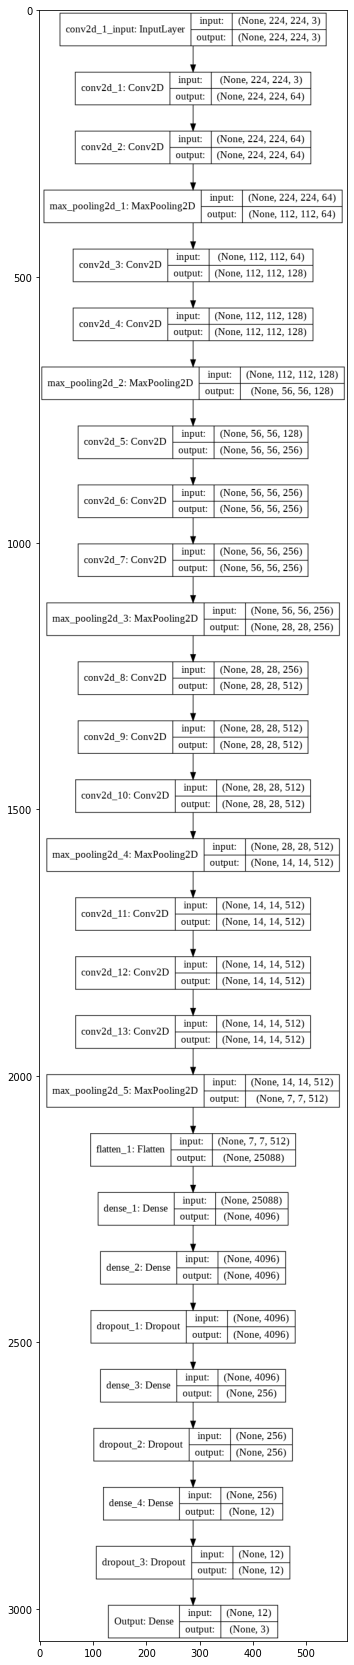

In [9]:
from keras.utils import plot_model
import matplotlib.image as mpimg
model_diag='/content/drive/My Drive/Colab Notebooks/WeaponProject/'

plot_model(model, to_file=model_diag+'VGG-model_dig.png',
           show_shapes=True,
           show_layer_names=True)

img=mpimg.imread(model_diag+'VGG-model_dig.png')
plt.figure(figsize=(60,30))
implt=plt.imshow(img)

**Compile The Model**

In [0]:
opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

**Creating checkpoit model**
to save loss and acc after each epoch

In [0]:
checkpoint = ModelCheckpoint("vgg16_1.h5", 
                             monitor='val_accuracy', verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False,
                             mode='auto', period=1)

**This fct To stop trining when we got the best rslts during the training**
the goal of this is to to mim the risque of** ouver fiting**

In [0]:
early = EarlyStopping(monitor='val_accuracy', 
                      min_delta=0, 
                      patience=20,
                      verbose=1, 
                      mode='auto')

**Fit The Model**

In [13]:
hist=model.fit_generator(
    train_generator,
    steps_per_epoch=training_samples // batch_size,
    epochs=12,
    callbacks=[checkpoint,early],
    validation_data=validation_generator,
    validation_steps=validation_samples // batch_size)

Epoch 1/12
26/26 [==============================] - 1536s 59s/step - loss: 1.1176 - accuracy: 0.3378 - val_loss: 1.0931 - val_accuracy: 0.4667

Epoch 00001: val_accuracy improved from -inf to 0.46667, saving model to vgg16_1.h5
Epoch 2/12
26/26 [==============================] - 1530s 59s/step - loss: 1.0994 - accuracy: 0.3244 - val_loss: 1.0977 - val_accuracy: 0.4667

Epoch 00002: val_accuracy did not improve from 0.46667
Epoch 3/12
26/26 [==============================] - 1542s 59s/step - loss: 1.0986 - accuracy: 0.3353 - val_loss: 1.0967 - val_accuracy: 0.6000

Epoch 00003: val_accuracy improved from 0.46667 to 0.60000, saving model to vgg16_1.h5
Epoch 4/12
26/26 [==============================] - 1517s 58s/step - loss: 1.0988 - accuracy: 0.3182 - val_loss: 1.0988 - val_accuracy: 0.2667

Epoch 00004: val_accuracy did not improve from 0.60000
Epoch 5/12
26/26 [==============================] - 1546s 59s/step - loss: 1.0986 - accuracy: 0.3413 - val_loss: 1.0994 - val_accuracy: 0.1333


**save model and weghits**

In [0]:
model.save('/content/drive/My Drive/Colab Notebooks/WeaponProject/VGG-16_model.h5')

In [0]:
model.save_weights("/content/drive/My Drive/Colab Notebooks/WeaponProject/VGG-16_model_wieghts.h5")

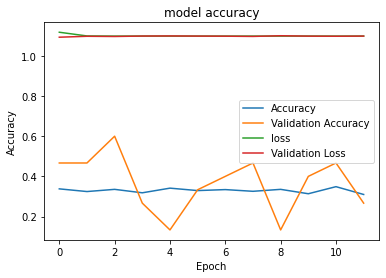

In [18]:
import matplotlib.pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

**To save the history fiele after the trainig**

In [0]:
pickle_out=open("/content/drive/My Drive/Colab Notebooks/WeaponProject/ChottVGG-16Model.pickle","wb")
pickle.dump(hist.history,pickle_out)
pickle_out.close()

**Loade the saving history from the pickle file**

In [22]:
pickle_in=open("/content/drive/My Drive/Colab Notebooks/WeaponProject/ChottVGG-16Model.pickle","rb")
saved_history=pickle.load(pickle_in)
print("this is my saved History of training".format(saved_history))

this is my saved History of training


**1-load saved Model**

In [23]:
weapon_model=load_model('/content/drive/My Drive/Colab Notebooks/WeaponProject/VGG-16_model.h5')
weapon_model.get_weights()
weapon_model.optimizer




**Evaluate The performence of my Modle**

In [39]:
print("Evaluate on test data")
score=weapon_model.evaluate(X_test, y_test , verbose=1)
print("test loss, test acc:", score)
#print("Test loss____", score[0])
#print("Test accurcy____",score[1])

Evaluate on test data
10/10 [==============================] - 5s 520ms/step
test loss, test acc: [1.0986000299453735, 0.4000000059604645]


In [40]:
mAP=weapon_model.evaluate(X_test,y_test)
print("Train and test mAP:",mAP)

10/10 [==============================] - 5s 510ms/step
Train and test mAP: [1.0986000299453735, 0.4000000059604645]


**Predection**

**Confusion Matrics**

In [41]:
y_pred=weapon_model.predict_classes( X_test)
print(classification_report(np.argmax(y_test,axis=1), y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           2       0.40      1.00      0.57         4

    accuracy                           0.40        10
   macro avg       0.20      0.50      0.29        10
weighted avg       0.16      0.40      0.23        10



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(np.argmax(y_test,axis=1), y_pred)
print(cm)

[[0 6]
 [0 4]]


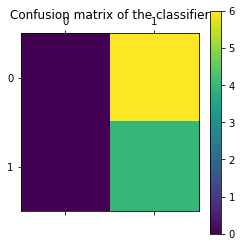

In [43]:
import pylab as pl
pl.matshow(cm)
pl.title('Confusion matrix of the classifier')
pl.colorbar()
pl.show()

**Show mis-classifications**

In [0]:
test_samples,test_labels=test_generator.next()
rslt=np.absolute(test_labels - y_pred)
rslt_inds=np.nonzero(rslt>0)
print("Indices of misclassified data are: \n\n"+str(rslt_inds))

**Test with image**

pass the image to the model for output

In [53]:
! pip install pillow

**Test1**

In [0]:
img = plt.imread("/content/drive/My Drive/Colab Notebooks/WeaponProject/Dataset/test/knife/15322a2b633e1fdb.jpg")
img=img.reshape(-1,224,224,3)
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)


output = weapon_model.predict(img)
if output[0][0] > output[0][1]:
    print("Handgun")
else:
    print('Knife')

**Test2**